# KI - Projekt: Evidenztheorie

Anhand von Sensor-Daten soll kassifiziert werden, ob es sich bei dem vermessenen Objekt um einen PKW, einen LKW, ein Motorrad oder ein Fahrrad handelt.
<br>
Folgende Kategorien werden unterschieden: <br>

| <b>KFZ-Art<b> | <b>Geschwindigkeit</b> | <b>Beschleunigung</b>| <b>Höhe</b> | <b>Breite</b> |
| --------------|------------------------|----------------------|-------------|-------------- |
| <b>Fahrrad</b> | Langsam | - | hoch | schmal |
| <b>PKW</b> | Mittel | - | flach | breit |
| <b>LKW</b> | Mittel | Schwach | hoch | breit |
| <b>Motorrad</b> | Mittel | Stark | hoch | schmal |

- Mittlere Geschwindigkeit zwischen 50 und 90 km/h.

## Schritte / Methoden:
1. Daten einlesen, explorieren + neue Datensätze berechnen.
2. Grenzwerte für 'hoch', 'flach', 'starke Beschleunigung', ... berechnen.
3. Einzelne Datensequenzen einlesen und Fahrzeugart mithilfe von `python_evidence`-Framework bestimmen.
  1. Werte (Geschw., Beschl., ...) bestimmen.
  2. Evidenz-Messungen (+ Wahrscheinlichkeiten) festlegen.
  3. Fahrzeugart bestimmen.

## Hinweis
- Sensoren arbeiten auf hohen Entfernungen ungenauer:
  - Mögliche Fehlerquelle, möglicherweise korrigieren / einberechnen.

In [23]:
# Imports
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import seaborn as sns
from matplotlib import gridspec
sns.set()

from python_evidence.dempster_handler import DempsterHandler, Measure
from utils import load_data, change_data, get_velocity, get_acceleration, save_data_dict, get_dimensions
from utils import get_max_range_by_criterion, get_acceleration_limit, calculate_weighted_ratio

# Daten einlesen und explorieren

--------------------------------------------------

Daten befinden sich in Form von CSV Dateien im [data](/data)-Ordner.

Sie bestehen aus jeweils einzelnen Mess-Sequenzen für ein Fahrzeug. Die Messdaten bestehen aus:
- t
  - Zeitpunkte (Messung alle 100ms)
- Eigengeschwindigkeit(m/s)
- Bbox_Breite
- Bbox_Höhe
- Bbox_links_unten_y
- Abstand(m)

In [24]:
# Location of CSV files
DATA_FOLDER = Path("data")
CSV_FILES = ["DPE15_1.csv", "DPE15_2.csv", "DPE15_3.csv", "DPE15_4.csv", 
             "DPE16_1.csv", "DPE16_2.csv", "DPE16_3.csv", "DPE16_4.csv"]

for ix, path in enumerate(CSV_FILES):
    CSV_FILES[ix] = DATA_FOLDER.joinpath(path)

# Load CSV file data.
data_dict = load_data(CSV_FILES)

"""
Explore data.
"""
df = data_dict["DPE15_1"]
display(df)

print(df.info())


,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m)
0,0,"16,1",61,121,142,71
1,"0,1","16,1",64,128,141,"70,5"
2,"0,2",16,64,127,138,69
3,"0,3","16,1",66,131,138,69
4,"0,4",16,67,134,137,"68,5"
...,...,...,...,...,...,...
99,"9,9","16,1",181,362,22,11
100,10,"16,2",183,366,20,10
101,"10,1","16,1",183,365,18,9
102,"10,2","16,1",230,374,18,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   t                          104 non-null    object
 1   Eigengeschwindigkeit(m/s)  104 non-null    object
 2   Bbox_Breite                104 non-null    int64 
 3   Bbox_Höhe                  104 non-null    int64 
 4   Bbox_links_unten_y         104 non-null    int64 
 5   Abstand(m)                 104 non-null    object
dtypes: int64(3), object(3)
memory usage: 5.0+ KB
None


# Neue Datensätz berechnen / Daten updaten.

-------------------------------------

* Anpassen der Datentypen.
* Berechnung von weiteren Daten:
  * Geschwindigkeit des anderen Fahrzeugs.
  * Dimensionen des anderen Fahrzeugs.



In [25]:
"""
* Eigengeschwindigkeit(m/s) to floats
* Convert velocity from m/s to km/h
* Abstand(m) to floats
* Timestamps to floats
* Calculate velocity and dimensions.
"""
change_data(data_dict)
MODELS = {}

# Calculate velocity and dimensions.
for path, df in data_dict.items():
    velocity_model, distance_model = get_velocity(df)
    MODELS.update({path: {"Velocity Model": velocity_model, "Distance Model": distance_model}})
    get_dimensions(df)

# Look at calculated / updated data.
print(data_dict["DPE16_2"].info())
display(data_dict["DPE16_2"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   t                          104 non-null    float64
 1   Eigengeschwindigkeit(m/s)  104 non-null    float64
 2   Bbox_Breite                104 non-null    int64  
 3   Bbox_Höhe                  104 non-null    int64  
 4   Bbox_links_unten_y         104 non-null    int64  
 5   Abstand(m)                 104 non-null    float64
 6   v(km/h)                    104 non-null    float64
 7   width                      104 non-null    float64
 8   height                     104 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 7.4 KB
None


,t,Eigengeschwindigkeit(m/s),Bbox_Breite,Bbox_Höhe,Bbox_links_unten_y,Abstand(m),v(km/h),width,height
0,0.0,22.0,304,226,87,43.5,73.908889,1.955,1.565
1,0.1,22.1,276,227,87,43.5,74.444299,1.815,1.570
2,0.2,22.1,279,230,87,43.5,74.974724,1.830,1.585
3,0.3,22.0,287,236,86,43.0,75.500163,1.865,1.610
4,0.4,22.2,283,233,86,43.0,76.020618,1.845,1.595
...,...,...,...,...,...,...,...,...,...
99,9.9,22.0,106,87,157,78.5,102.730354,1.315,1.220
100,10.0,22.1,104,85,159,79.5,102.772210,1.315,1.220
101,10.1,22.0,126,77,162,81.0,102.809081,1.440,1.195
102,10.2,22.1,101,83,161,80.5,102.840966,1.310,1.220


## Geschwindigkeit & Beschleunigung

Aufgrund von enormen Schwankung bei den direkt vermessenen Daten (siehe Plots), wird folgende Methodik verwendet:
1. Ploynomiale Regression über die Messdaten. Ziel: 'Mittlung' der Messdaten macht Messfehler / Schwankungen transparent.
2. Ableitung des errechneten Geschwindigkeits-Modells liefert die Beschleunigung.

Alle errechneten Daten / Regressionen jedes Datensatz werden geplottet.

## Erkenntnisse

* Die polynomiale Regression hat teilweise an den Grenzen der Zeitachse enorme Steigungen (vgl DPE16_4).
  * Eine mögliche Lösung dieses 'Problems' wäre das Abschneiden der Enden.


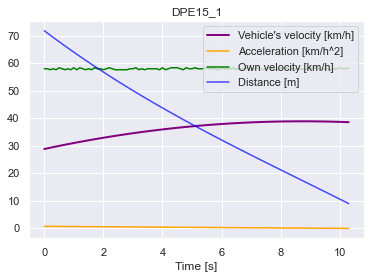

In [26]:
# Calculate acceleration
for path, df in data_dict.items():
    get_acceleration(df, MODELS[path]["Velocity Model"])

# Save data in dictionary for further calculations
save_data_dict(data_dict, Path("updated_data"))
    
path, df = list(data_dict.items())[0]
plt.title(path)
plt.xlabel("Time [s]")
velocity_key = "v(km/h)"

# Plot optimized velocity
plt.plot(df["t"], df[velocity_key], linewidth=2, color="purple", label="Vehicle's velocity [km/h]")

# Plot acceleration
plt.plot(df["t"], df["a(km/h^2)"], color="orange", label="Acceleration [km/h^2]")

# Plot the velocity of the data recording vehicle
plt.plot(df["t"], df["Eigengeschwindigkeit(m/s)"]  * 3.6, color="green", label="Own velocity [km/h]")

# Plot the distances.
plt.plot(df["t"], MODELS[path]["Distance Model"](df["t"]), color="blue", alpha=0.7, label="Distance [m]")

plt.legend()
plt.show()

## Wichtige Daten herausfinden

Einige Daten / Grenzwerte sind interessant für die spätere Auswertung:
* Maximal und minimal Geschwindigkeiten.
* Maximal und minimal Beschleunigungen.
* Verhältnis von Höhe und Breite.

DPE15_1
_______________________________________
Velocity:     min: 28.77359676886199    max: 38.84589351002987
Acceleration: min: -0.11524277440190445  max: 0.6409605509089926
Height : Width ratio 1.6586129519601869


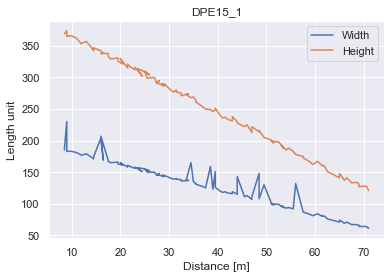

In [27]:
path, df = list(data_dict.items())[0]
plt.title(path)
plt.plot(df["Abstand(m)"], df["Bbox_Breite"], label="Width")
plt.plot(df["Abstand(m)"], df["Bbox_Höhe"], label="Height")

print(path)
print("_______________________________________")

# Print min and max of velocity / acceleration.
print("Velocity:     min:", df["v(km/h)"].min(), "   max:", df["v(km/h)"].max())
print("Acceleration: min:", df["a(km/h^2)"].min(), " max:", df["a(km/h^2)"].max())

# Print height to width ratios
height_width_ratio = calculate_weighted_ratio(df["height"], df["width"], df["Abstand(m)"])
print("Height : Width ratio", height_width_ratio)
#plt.plot(df["Abstand(m)"], df["height"], label="amk")

plt.legend()
plt.xlabel("Distance [m]")
plt.ylabel("Length unit")
plt.show()

# Evidenzen

* Berechnen einiger Limits.
* evidenz-Messungen festlegen anhand von gemessenen Daten.
* Ergebnisse plotten.

DPE15_1 
-------------------------
Velocity is lower 50 km/h
Low acceleration
High and narrow
Correcting with  1.5384615384615383


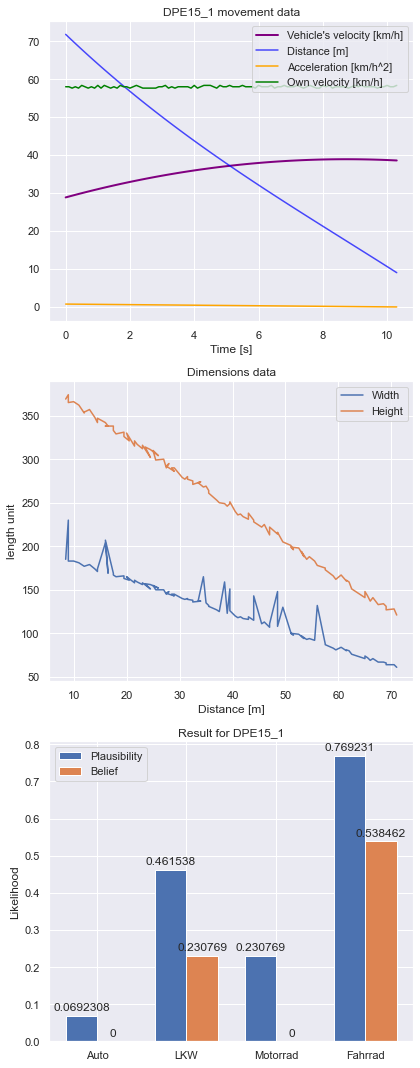



DPE15_2 
-------------------------
Velocity is greater 90 km/h
High acceleration
High and narrow


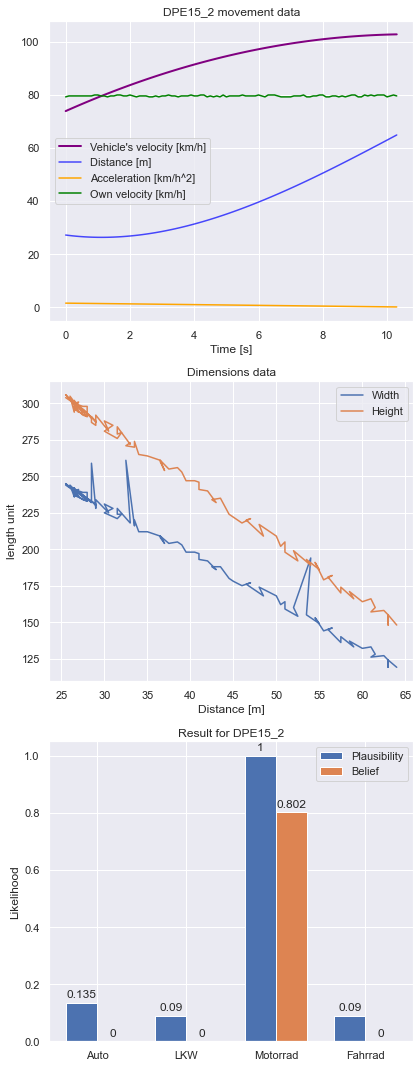



DPE15_3 
-------------------------
Velocity is greater 90 km/h
High acceleration
flat and wide
Correcting with  1.6260162601626016


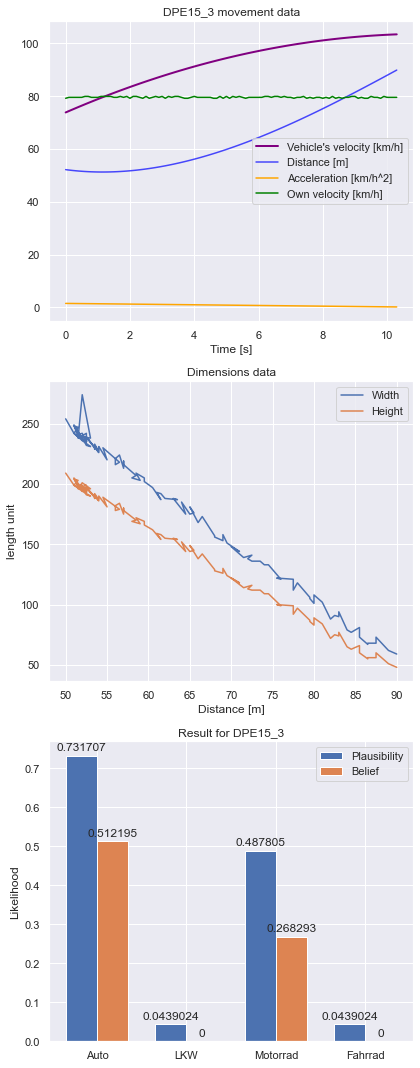



DPE15_4 
-------------------------
Velocity is between 50 and 90 km/h
Low acceleration
High and narrow


In [ ]:
# Get dynamic acceleration limits
ACCELERATION_LIMIT_UPPER = get_acceleration_limit(data_dict, limit=0.75)
ACCELERATION_LIMIT_LOWER =  get_acceleration_limit(data_dict, limit=0.25)

def plot_data(df, title, pls, blfs, categories):
    """
    Plot plausibilities and beliefs
    """
    width = 0.35
    x = np.arange(len(categories))
    fig = plt.figure()
    spec = gridspec.GridSpec(ncols=1, nrows=3)
    velocity_key = "v(km/h)"
    fig.set_figheight(15)
    
    """
    Plot optimized velocity
    """
    ax0 = fig.add_subplot(spec[0])
    ax0.plot(df["t"], df[velocity_key], linewidth=2, color="purple", label="Vehicle's velocity [km/h]")
    ax0.plot(df["t"], MODELS[title]["Distance Model"](df["t"]), color="blue", alpha=0.7, label="Distance [m]")
    ax0.plot(df["t"], df["a(km/h^2)"], color="orange", label="Acceleration [km/h^2]")
    ax0.set_title(title + " movement data")
    ax0.set_xlabel("Time [s]")
    ax0.plot(df["t"], df["Eigengeschwindigkeit(m/s)"]  * 3.6, color="green", label="Own velocity [km/h]")
    ax0.legend()
    
    """
    Plot width / heigh over distance
    """
    ax1 = fig.add_subplot(spec[1])
    ax1.plot(df["Abstand(m)"], df["Bbox_Breite"], label="Width")
    ax1.plot(df["Abstand(m)"], df["Bbox_Höhe"], label="Height")
    ax1.legend()
    ax1.set_ylabel("length unit")
    ax1.set_xlabel("Distance [m]")
    ax1.set_title("Dimensions data")
    
    """
    Plot beliefs and plausibilities.
    """
    ax2 = fig.add_subplot(spec[2])
    rects1 = ax2.bar(x - width/2, pls, width, label="Plausibility")
    rects2 = ax2.bar(x + width/2, blfs, width, label="Belief")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax2.set_ylabel("Likelihood")
    ax2.set_xticks(x, categories)
    ax2.legend()
    ax2.bar_label(rects1, padding=3)
    ax2.bar_label(rects2, padding=3)
    ax2.set_title("Result for " + title)

    fig.tight_layout()
    if not Path("pics").exists():
        Path("pics").mkdir()
    ax2.figure.savefig(F"pics/{title}.png")
    plt.show()
   

# Estimate the category of the measured vehicle
def estimate_vehicle_type(df, title):
    """ estimate type of vehicle, based on bounding box, speed and acceleration"""
    handler = DempsterHandler(["Auto", "LKW", "Motorrad", "Fahrrad"])
    
    print(title, "\n-------------------------")
    # Check type of vehicle on basis of its velocity
    # At a speed greater than 50 it is unlikely to deal with a bicycle
    range_speed_greater_50 = get_max_range_by_criterion(df["v(km/h)"], lambda x : x >= 50)
    range_speed_greater_90 = get_max_range_by_criterion(df["v(km/h)"], lambda x : x >= 90)
    if range_speed_greater_50 >= 10 and range_speed_greater_90 < 10:
        print("Velocity is between 50 and 90 km/h")
        handler.add_measure([
            Measure(["Auto", "LKW", "Motorrad"], 0.8)
        ])
    elif range_speed_greater_50 < 10:
        print("Velocity is lower 50 km/h")
        handler.add_measure([
            Measure(["Fahrrad"], 0.7)
        ])
    elif range_speed_greater_90 >= 10:
        print("Velocity is greater 90 km/h")
        handler.add_measure([
            Measure(["Auto", "Motorrad"], 0.8)
        ])

    # Check type of vehicle on basis of its acceleration
    # A high acceleration could indicate a motorcycle
    if get_max_range_by_criterion(df["a(km/h^2)"],
                                 lambda x : abs(x) >= ACCELERATION_LIMIT_UPPER) >= 5:
        print("High acceleration")
        handler.add_measure([
            Measure(["Motorrad"], 0.55)
        ])
    elif get_max_range_by_criterion(df["a(km/h^2)"],
                                   lambda x : abs(x) <= ACCELERATION_LIMIT_LOWER) >= 5:
        print("Low acceleration")
        handler.add_measure([
            Measure(["LKW"], 0.5)
        ])

    # Check height to width ratio
    # A ratio >= 1 (taller than wide) could indicate a Motorrad, Fahrrad or LKW
    height_width_ratio = calculate_weighted_ratio(df["height"], df["width"], df["Abstand(m)"])
    if height_width_ratio >= 1.0:
        print("High and narrow")
        handler.add_measure([
            Measure(["Motorrad", "Fahrrad", "LKW"], 0.7)
        ])
    else:
        print("flat and wide")
        handler.add_measure([
            Measure(["Auto"], 0.7)
        ])
    
    # Accumulate measures and calculate plausibilities and beliefs
    accumulate = handler.accumulate()
    pls = []
    blfs = []
    categories = handler.categories()
    for category in categories:
        p = handler.plausibility(accumulate, category)
        b = handler.belief(accumulate, category)
        pls.append(p)
        blfs.append(b)
       
    # Plot the corresponding graphs.
    plot_data(df, title, pls, blfs, categories)
    print("\n")
    

# Estimate types for all sensor datas.
for name, df in data_dict.items():
    estimate_vehicle_type(df, name)